In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import scipy
import seaborn as sns

# sys.path.append("/Users/fgu/dev/projects/entropy/src")
# import src.config as cf
# import src.data.aggregators as ag
# import src.data.validators as vl
# import src.helpers.data as hd

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

In [6]:
fs.ls("3di-data-mdb/clean/samples")

['3di-data-mdb/clean/samples/',
 '3di-data-mdb/clean/samples/mdb_1000.parquet',
 '3di-data-mdb/clean/samples/mdb_111.parquet',
 '3di-data-mdb/clean/samples/mdb_X11.parquet',
 '3di-data-mdb/clean/samples/mdb_costa.parquet']

In [4]:
dft = hd.read_txn_data("111")
hd.inspect(dft)

Time for read_txn_data                 : 1.84 minutes
shape: (593,133, 35), users: 270


,date,user_id,amount,desc,merchant,tag_group,tag_spend,user_registration_date,account_created,account_id,account_last_refreshed,account_provider,account_type,birth_year,data_warehouse_date_created,data_warehouse_date_last_updated,id,is_debit,is_female,is_sa_flow,is_salary_pmt,is_urban,latest_balance,lsoa,merchant_business_line,msoa,postcode,region_name,salary_range,tag,tag_auto,tag_manual,tag_up,updated_flag,ym
0,2012-01-03,111,-114.0,<mdbremoved>,NaN,NaN,NaN,2010-06-19,2016-10-30,235634,2018-08-08 10:24:00,lloyds bank,current,NaN,2014-07-18,2015-03-19,397323,False,0.0,False,False,1.0,0.5,e01001036,NaN,e02000222,cr2 7,london,,NaN,NaN,no tag,no tag,u,2012-01
1,2012-01-03,111,8.5,<mdbremoved>,NaN,NaN,NaN,2010-06-19,2016-10-30,235634,2018-08-08 10:24:00,lloyds bank,current,NaN,2014-07-18,2015-03-19,397324,True,0.0,False,False,1.0,0.5,e01001036,NaN,e02000222,cr2 7,london,,NaN,NaN,no tag,no tag,u,2012-01


## testing

In [255]:
dfa = hd.read_analysis_data("XX0")
hd.inspect(dfa)

shape: (102,302, 188), users: 3345


,user_id,ym,ymn,month,txns_count,txns_volume,txns_count_spend,txns_count_sa,txns_count_ca,has_benefits,has_od_fees,month_income,year_income,month_income_mean,income_var,has_month_income,inflows,outflows,netflows,netflows_norm,inflows_norm,outflows_norm,has_pos_netflows,pos_netflows,has_inflows,user_reg_ym,month_spend,age,is_female,region,is_urban,region_code,has_savings_account,has_current_account,generation,generation_code,prop_credit,accounts_active,accounts_total,investments,up_savings,ca_transfers,cc_payments,loan_funds,loan_rpmts,nunique_tag,nunique_tag_spend,nunique_merchant,dspend,dspend_count,dspend_mean,dspend_clothes,dspend_entertainment,dspend_food,dspend_groceries,dspend_other,dspend_dd,entropy_tag,entropy_tag_z,entropy_tag_s,...,sp_tag_spend_charity,sp_tag_spend_children,sp_tag_spend_jewellery,sp_tag_spend_garden,sp_tag_spend_accessories,sp_tag_spend_fines,sp_tag_spend_education,sp_tag_spend_flowers,sp_tag_spend_legal,sp_tag_spend_pet,sp_tag_spend_administration,sp_tag_spend_art,sp_tag_spend_childcare,ct_tag_spend_household,ct_tag_spend_insurance,ct_tag_spend_cash,ct_tag_spend_groceries,ct_tag_spend_phone and mobile,ct_tag_spend_bank charges,ct_tag_spend_reading,"ct_tag_spend_entertainment, tv, media",ct_tag_spend_energy and water,ct_tag_spend_taxes,ct_tag_spend_public transport,ct_tag_spend_hobbies,ct_tag_spend_loan repayment,ct_tag_spend_eating out,ct_tag_spend_personal care,ct_tag_spend_home,ct_tag_spend_vehicle hire,ct_tag_spend_holidays,ct_tag_spend_clothes and shoes,ct_tag_spend_appliances,ct_tag_spend_entertainment,ct_tag_spend_health care,ct_tag_spend_diy,ct_tag_spend_vehicle,ct_tag_spend_office,ct_tag_spend_alcohol,ct_tag_spend_sports,ct_tag_spend_gifts,ct_tag_spend_housing,ct_tag_spend_flights,ct_tag_spend_business expenses,ct_tag_spend_financial,ct_tag_spend_taxi,ct_tag_spend_gambling,ct_tag_spend_charity,ct_tag_spend_children,ct_tag_spend_jewellery,ct_tag_spend_garden,ct_tag_spend_accessories,ct_tag_spend_fines,ct_tag_spend_education,ct_tag_spend_flowers,ct_tag_spend_legal,ct_tag_spend_pet,ct_tag_spend_administration,ct_tag_spend_art,ct_tag_spend_childcare
0,1210,2012-02,201202,2,89.0,24168.910156,62,3.0,37.0,0,0,5.20883,59.788048,4.982337,0.458021,1,10.0,2000.0,-1990.0,-382.043579,1.919817,383.963379,0,-0.0,1,2012-01,5.39587,44.0,0.0,north west,1.0,8,True,True,Gen X,2,0.452722,7,15,39.75,0.0,3282.010010,3242.260010,0.0,0.0,9,22,23,1239.489990,25.0,49.579601,66.00,0.00,18.25,382.890015,772.349976,0.0,2.680826,1.055741,2.794094,...,0.0,0.3672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,5.0,16.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,4.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,7.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1210,2012-03,201203,3,88.0,20173.070312,61,2.0,39.0,0,0,4.82800,59.788048,4.982337,0.325535,1,10.0,0.0,10.0,2.071251,2.071251,0.000000,1,10.0,1,2012-01,4.19900,44.0,0.0,north west,1.0,8,True,True,Gen X,2,0.275532,6,15,39.75,0.0,3242.350098,2396.600098,0.0,0.0,8,19,22,672.849976,25.0,26.914000,29.99,18.77,12.38,551.710022,60.000000,0.0,2.525209,0.785321,2.694468,...,0.0,0.3380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,8.0,20.0,1.0,3.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,8.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [323]:
dfa.to_csv("/Users/fgu/entropy_data_new.csv")

In [324]:
dfa.filter(regex="^ct_tag_(?!spend)")

,ct_tag_services,ct_tag_finance,ct_tag_other_spend,ct_tag_household,ct_tag_communication,ct_tag_retail,ct_tag_travel,ct_tag_hobbies,ct_tag_motor
0,6.0,9.0,5.0,24.0,2.0,7.0,2.0,2.0,5.0
1,6.0,7.0,8.0,26.0,2.0,4.0,0.0,3.0,5.0
2,4.0,7.0,11.0,28.0,2.0,8.0,2.0,6.0,5.0
3,9.0,6.0,5.0,23.0,2.0,5.0,1.0,1.0,5.0
4,10.0,3.0,8.0,28.0,2.0,5.0,1.0,2.0,4.0
...,...,...,...,...,...,...,...,...,...
102297,12.0,2.0,5.0,15.0,3.0,7.0,0.0,1.0,3.0
102298,5.0,3.0,0.0,11.0,3.0,3.0,0.0,1.0,1.0
102299,2.0,1.0,2.0,14.0,3.0,4.0,0.0,1.0,0.0
102300,11.0,1.0,0.0,20.0,3.0,5.0,1.0,1.0,2.0


In [286]:
import functools

equal_to_txns_count_spend = functools.partial(
    pd.testing.assert_series_equal,
    right=dfa.txns_count_spend,
    check_dtype=False,
    check_names=False,
)

equal_to_txns_count_spend(dfa.filter(regex="^ct_tag_spend", axis=1).sum(1))
equal_to_txns_count_spend(dfa.filter(regex="^ct_tag_(?!spend)", axis=1).sum(1))

In [320]:
equal_to_month_spend = functools.partial(
    pd.testing.assert_series_equal,
    right=dfa.month_spend,
    check_dtype=False,
    check_names=False,
    rtol=1,
)

equal_to_month_spend(dfa.filter(regex="^sp_tag_(?!spend)", axis=1).sum(1))
equal_to_month_spend(dfa.filter(regex="^sp_tag_spend", axis=1).sum(1))

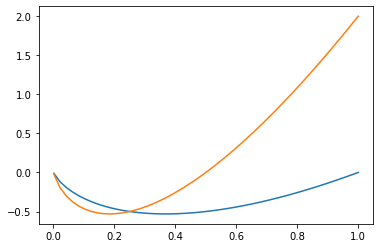

In [28]:
import math

x = np.linspace(0.001, 1, 50)
plt.plot(x, x * np.log2(x))
plt.plot(x, 2 * x * np.log2(2 * x))